In [1]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126
     ---------------------------------------- 0.0/6.2 MB ? eta -:--:--
     ---------------------------------------- 6.2/6.2 MB 42.0 MB/s eta 0:00:00
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 GB 112.3 MB/s eta 0:00:23
    --------------------------------------- 0.1/2.5 GB 127.2 MB/s eta 0:00:20
   - -------------------------------------- 0.1/2.5 GB 137.1 MB/s eta 0:00:18
   - -------------------------------------- 0.1/2.5 GB 142.8 MB/s eta 0:00:17
   -- ------------------------------------- 0.2/2.5 GB 153.3 MB/s eta 0:00:16
   --- ------------------------------------ 0.2/2.5 GB 164.0 MB/s eta 0:00:14
   ---- ----------------------------------- 0.3/2.5 GB 177.4 MB/s eta 0:00:13
   ---- ----------------------------------- 0.3/2.5 GB 204.4 MB/s eta 0:00:11
   ----- --


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# read CSV
def load_labels(csv_path):
    df = pd.read_csv(csv_path, header=None, names=["folder", "label"])
    data = []
    for _, row in df.iterrows():
        image_paths = glob(os.path.join(row["folder"], "*.png")) 
        label = row["label"]
        for img_path in image_paths:
            data.append((img_path, label))
    return data

# define dataset
class MURADataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])


train_data = load_labels("MURA-v1.1/train_labeled_studies.csv")
valid_data = load_labels("MURA-v1.1/valid_labeled_studies.csv")
train_dataset = MURADataset(train_data, transform)
valid_dataset = MURADataset(valid_data, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


In [4]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models.efficientnet import EfficientNet_B3_Weights

# EfficientNet-B3 as classifier
class MURAModel(nn.Module):
    def __init__(self):
        super(MURAModel, self).__init__()
        self.model = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)  
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)  # modify last layer

    def forward(self, x):
        return self.model(x)

model = MURAModel().cuda()


In [7]:
import torch
import torch.optim as optim
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.4893
Epoch [2/10], Loss: 0.4045
Epoch [3/10], Loss: 0.3367
Epoch [4/10], Loss: 0.2647
Epoch [5/10], Loss: 0.1960
Epoch [6/10], Loss: 0.1408
Epoch [7/10], Loss: 0.1146
Epoch [8/10], Loss: 0.0949
Epoch [9/10], Loss: 0.0778
Epoch [10/10], Loss: 0.0721


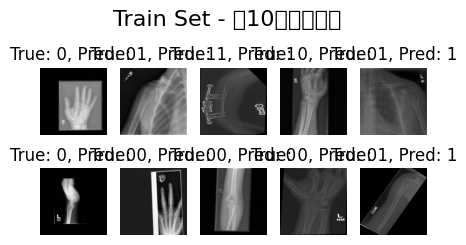

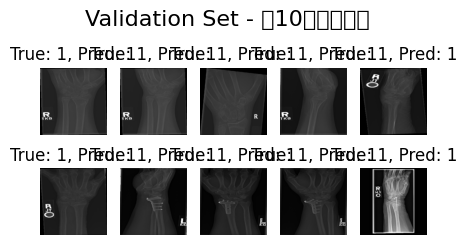

In [15]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.save(model.state_dict(), "best_model_3d_Mar19.pth")
model.eval()

def visualize_predictions(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()  
            predictions = (probs > 0.5).astype(int)  

            for i in range(len(images)):
                if images_shown >= 10:
                    break
                plt.subplot(4, 5, images_shown + 1)
                img = images[i].cpu().permute(1, 2, 0).numpy()  
                img = (img - img.min()) / (img.max() - img.min())

                plt.imshow(img, cmap="gray")
                plt.title(f"True: {int(labels[i].item())}, Pred: {predictions[i][0]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= 10:
                break

    plt.suptitle(f"{dataset_name} - 10", fontsize=16)
    plt.show()

visualize_predictions(train_loader, "Train Set")
visualize_predictions(valid_loader, "Validation Set")


construct CAM


In [5]:
model = MURAModel().cuda()
model.load_state_dict(torch.load("best_model_3d_Mar19.pth"))
model.eval()
print("load model！")


load model！


In [17]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F

target_layer = model.model.features[-1]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output  

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  

    def generate_cam(self, input_image):
        input_image = input_image.unsqueeze(0).cuda()
        self.model.zero_grad()

        output = self.model(input_image)  
        output.backward(retain_graph=True)  

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)  # GAP to get weight
        cam = (weights * self.activations).sum(dim=1, keepdim=True) 
        cam = F.relu(cam) 
        cam = cam.squeeze().cpu().detach().numpy()  
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (224, 224)) 
        return cam

grad_cam = GradCAM(model, target_layer)


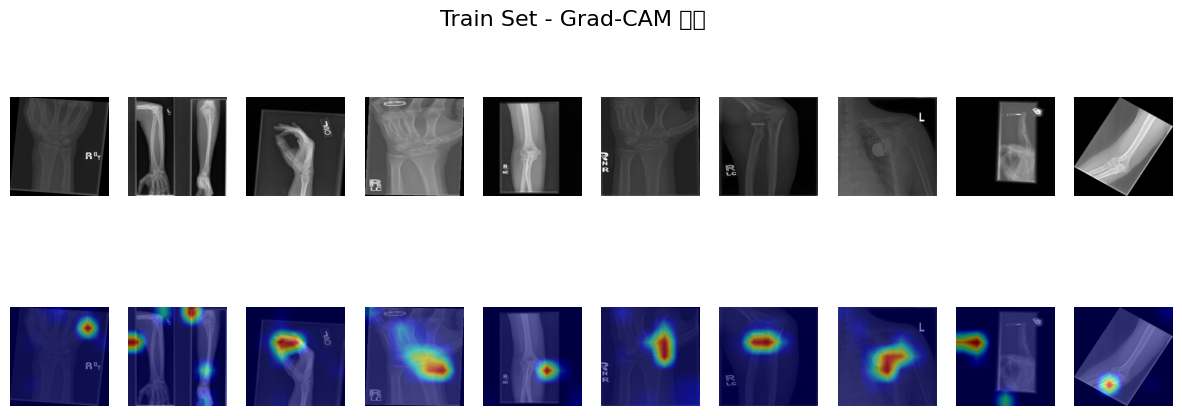

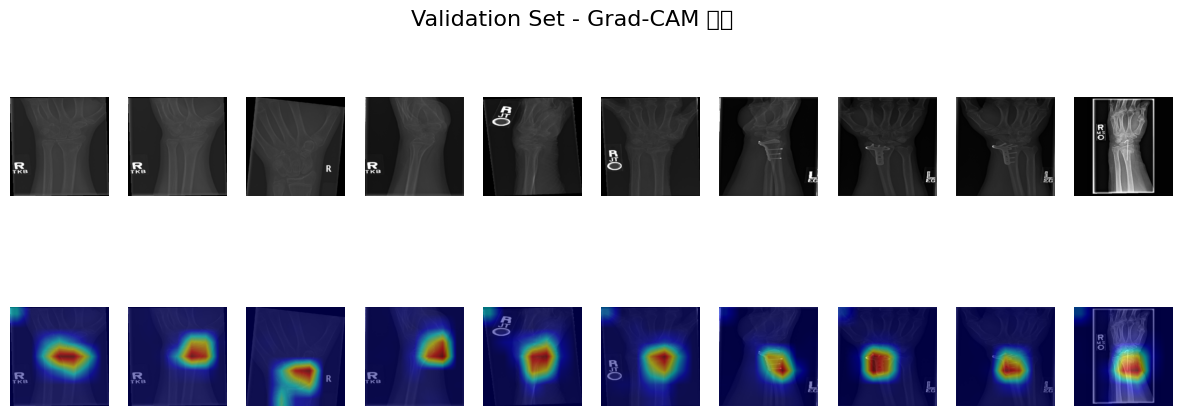

In [33]:
def visualize_cam(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break

            # compute CAM
            cam = grad_cam.generate_cam(images[i])
            img = images[i].cpu().permute(1, 2, 0).numpy() 
            img = (img - img.min()) / (img.max() - img.min())  

            # overlay CAM to original
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = (0.5 * heatmap + 0.5 * img * 255).astype(np.uint8)

            # plot original image and CAM
            plt.subplot(2, 10, images_shown + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")

            plt.subplot(2, 10, images_shown + 11)
            plt.imshow(overlay)
            plt.axis("off")

            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Grad-CAM ", fontsize=16)
    plt.show()


visualize_cam(train_loader, "Train Set")
visualize_cam(valid_loader, "Validation Set")


In [34]:
def generate_bounding_box(cam, box_size=50):

    h, w = cam.shape
    max_idx = np.unravel_index(np.argmax(cam), cam.shape)  # find the lightest point
    center_x, center_y = max_idx[1], max_idx[0]  # turn to (x, y)
    # compute Bounding Box 
    half_size = box_size // 2
    x1, y1 = max(0, center_x - half_size), max(0, center_y - half_size)
    x2, y2 = min(w, center_x + half_size), min(h, center_y + half_size)

    return (x1, y1, x2, y2), (center_x, center_y)


Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8


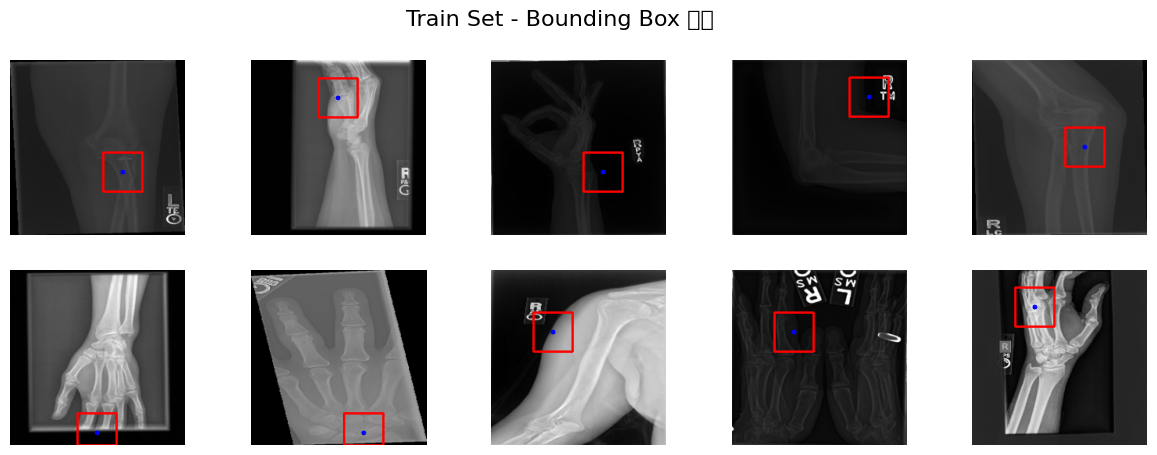

Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8


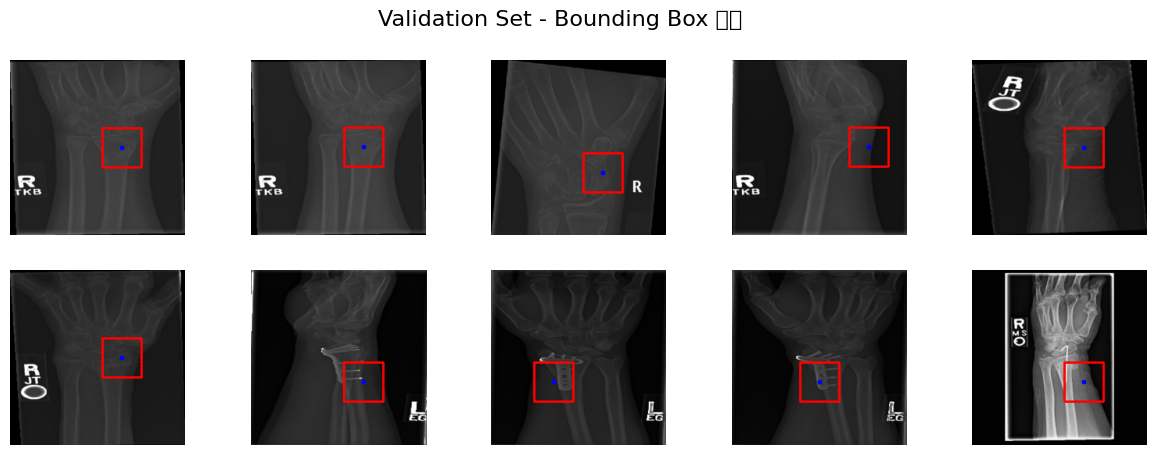

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(loader, dataset_name, box_size=50):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break

            # compute CAM
            cam = grad_cam.generate_cam(images[i])
            bbox, center = generate_bounding_box(cam, box_size=box_size)
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())  
            img = (img * 255).astype(np.uint8)  
            if img.ndim == 2: 
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[-1] == 1:  
                img = np.repeat(img, 3, axis=-1)

            print(f"Image Shape: {img.shape}, dtype: {img.dtype}")
            img = np.array(img, dtype=np.uint8)  
            x1, y1, x2, y2 = bbox
            img = cv2.rectangle(img.copy(), (x1, y1), (x2, y2), (255, 0, 0), 2) 
            img = cv2.circle(img.copy(), center, 3, (0, 0, 255), -1)  ）
            plt.subplot(2, 5, images_shown + 1)
            plt.imshow(img)
            plt.axis("off")

            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Bounding Box", fontsize=16)
    plt.show()

visualize_bbox(train_loader, "Train Set")
visualize_bbox(valid_loader, "Validation Set")


In [43]:
import os
import pandas as pd
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.efficientnet import EfficientNet_B3_Weights
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


class MURAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)

    def forward(self, x):
        return self.model(x)

class GradCAMWrapper:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.forward_hook = target_layer.register_forward_hook(self.save_activations)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output  
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor):
        self.model.zero_grad()
        
        with torch.set_grad_enabled(True):

            input_var = input_tensor.unsqueeze(0).requires_grad_(True)
            output = self.model(input_var)
            one_hot = torch.ones_like(output)
            output.backward(gradient=one_hot, retain_graph=False)
            
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(1, keepdim=True)
        cam = torch.relu(cam).squeeze()
        cam = cam.detach().cpu().numpy()

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (224, 224))
        return cam

    def __del__(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

def generate_bbox_coordinates(data_list, output_csv):

    model = MURAModel()
    model.load_state_dict(
        torch.load("best_model_3d_Mar19.pth", 
                  map_location='cuda' if torch.cuda.is_available() else 'cpu',
                  weights_only=True)
    )
    model = model.eval().cuda() if torch.cuda.is_available() else model.eval()
    target_layer = model.model.features[-1]
    gradcam = GradCAMWrapper(model, target_layer)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    results = []
    for img_path, _ in tqdm(data_list):
        img = Image.open(img_path).convert("RGB")
        tensor_img = transform(img).to(next(model.parameters()).device)
        cam = gradcam.generate_cam(tensor_img)  
        max_idx = np.unravel_index(cam.argmax(), cam.shape)
        center_x, center_y = max_idx[1], max_idx[0]
        box_size = 50
        half_size = box_size // 2
        
        x1 = max(0, center_x - half_size)
        y1 = max(0, center_y - half_size)
        x2 = min(224, center_x + half_size)
        y2 = min(224, center_y + half_size)
        
        results.append([img_path, x1, y1, x2, y2])
    
    pd.DataFrame(results, columns=["path", "x1", "y1", "x2", "y2"]).to_csv(output_csv, index=False)

class BoundingBoxDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        tensor_img = self.transform(img)
        bbox = torch.tensor([row["x1"], row["y1"], row["x2"], row["y2"]], dtype=torch.float32)
        return tensor_img, bbox

class BBoxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, 4)
    
    def forward(self, x):
        return self.base(x)

def train_bbox_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_dataset = BoundingBoxDataset("train_bbox.csv")
    valid_dataset = BoundingBoxDataset("valid_bbox.csv")
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=16)

    model = BBoxModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    for epoch in range(20):
        model.train()
        train_loss = 0.0
        for imgs, bboxes in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, bboxes = imgs.to(device), bboxes.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, bboxes)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, bboxes in valid_loader:
                imgs, bboxes = imgs.to(device), bboxes.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, bboxes).item() * imgs.size(0)
        
        train_loss /= len(train_dataset)
        val_loss /= len(valid_dataset)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_bbox_model.pth")

#visualize
def visualize_bbox(model_path="best_bbox_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BBoxModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    dataset = BoundingBoxDataset("valid_bbox.csv")
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    with torch.no_grad():
        imgs, true_bboxes = next(iter(loader))
        imgs = imgs.to(device)
        pred_bboxes = model(imgs).cpu().numpy()
        true_bboxes = true_bboxes.numpy()
        
        plt.figure(figsize=(15, 10))
        for i in range(4):
            img = imgs[i].cpu().permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  
            
            # real bbox
            x1, y1, x2, y2 = true_bboxes[i]
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 1, 0), 2)
            
            # predict bbox
            px1, py1, px2, py2 = pred_bboxes[i]
            cv2.rectangle(img, (int(px1), int(py1)), (int(px2), int(py2)), (1, 0, 0), 2)
            
            plt.subplot(2, 2, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":

    train_data = load_labels("MURA-v1.1/train_labeled_studies.csv") 
    valid_data = load_labels("MURA-v1.1/valid_labeled_studies.csv")
    generate_bbox_coordinates(train_data, "train_bbox.csv")
    generate_bbox_coordinates(valid_data, "valid_bbox.csv")
    
    train_bbox_model()
    visualize_bbox()

  0%|                                                                                                          | 0/36808 [00:00<?, ?it/s]D:\pytorchMethod\imageclass\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.86it/s]


Train Loss: 6239.8041 | Val Loss: 2374.7908


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.85it/s]


Train Loss: 2774.9814 | Val Loss: 2314.7039


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.84it/s]


Train Loss: 2738.7242 | Val Loss: 2271.6698


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.85it/s]


Train Loss: 2704.9041 | Val Loss: 2256.9118


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.86it/s]


Train Loss: 2653.6500 | Val Loss: 2275.8138


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.88it/s]


Train Loss: 2566.9199 | Val Loss: 2296.9292


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.82it/s]


Train Loss: 2439.4939 | Val Loss: 2346.2131


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.85it/s]


Train Loss: 2276.9910 | Val Loss: 2374.7617


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.87it/s]


Train Loss: 2082.0955 | Val Loss: 2481.4866


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:33<00:00, 10.80it/s]


Train Loss: 1907.9974 | Val Loss: 2488.9009


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.84it/s]


Train Loss: 1750.4576 | Val Loss: 2360.0346


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.87it/s]


Train Loss: 1589.5777 | Val Loss: 2387.5772


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.85it/s]


Train Loss: 1410.6613 | Val Loss: 2521.0954


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.84it/s]


Train Loss: 1220.5192 | Val Loss: 2643.6747


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.85it/s]


Train Loss: 1051.3235 | Val Loss: 2693.1237


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.85it/s]


Train Loss: 924.0809 | Val Loss: 2728.6612


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.82it/s]


Train Loss: 824.4220 | Val Loss: 2702.3751


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.83it/s]


Train Loss: 741.6116 | Val Loss: 2765.5929


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:31<00:00, 10.86it/s]


Train Loss: 676.1402 | Val Loss: 2739.0448


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:32<00:00, 10.83it/s]


Train Loss: 630.3294 | Val Loss: 2701.9757


C:\Users\12905\AppData\Local\Temp\ipykernel_26368\1133618241.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


<Figure size 1500x1000 with 0 Axes>

In [45]:
torch.save(model.state_dict(), "best_bbox_model2.pth")

In [48]:
dataset = BoundingBoxDataset("valid_bbox.csv")
print(len(dataset)) 

3197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


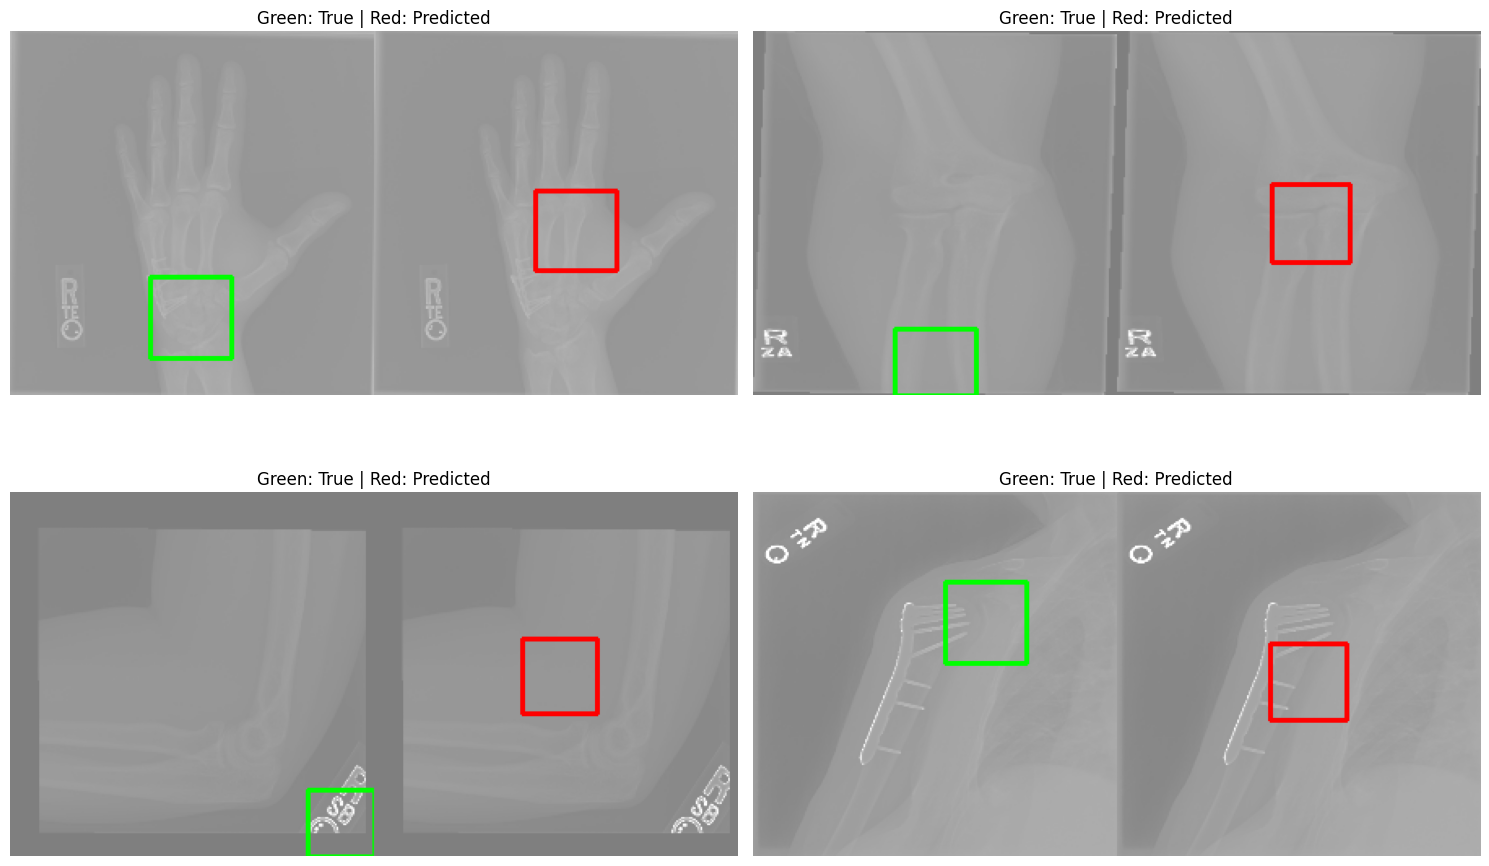

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import EfficientNet_B3_Weights
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader

def visualize_bbox(model_path="best_bbox_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    class BBoxModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.base = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
            self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, 4)
        
        def forward(self, x):
            return self.base(x)

    model = BBoxModel().to(device)
    try:
        model.load_state_dict(
            torch.load(model_path, map_location=device, weights_only=True)
        )
    except RuntimeError as e:
        print(f"load model false: {str(e)}")
        return
    
    model.eval()
    dataset = BoundingBoxDataset("valid_bbox.csv")
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    with torch.no_grad():
        imgs, true_bboxes = next(iter(loader))
        imgs = imgs.to(device)
        pred_bboxes = model(imgs).cpu().numpy()
        true_bboxes = true_bboxes.numpy()
        
        plt.figure(figsize=(15, 10))
        for i in range(4):
            img = imgs[i].cpu().permute(1, 2, 0).numpy()
            img = (img * 0.5) + 0.5  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_true = img.copy()
            img_pred = img.copy()
            
            x1, y1, x2, y2 = true_bboxes[i].astype(int)
            cv2.rectangle(img_true, (x1, y1), (x2, y2), (0, 255, 0), 2)
            px1, py1, px2, py2 = pred_bboxes[i].astype(int)
            cv2.rectangle(img_pred, (px1, py1), (px2, py2), (255, 0, 0), 2)
            plt.subplot(2, 2, i+1)
            plt.imshow(np.hstack([img_true, img_pred]))
            plt.title(f"Green: True | Red: Predicted")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

visualize_bbox()

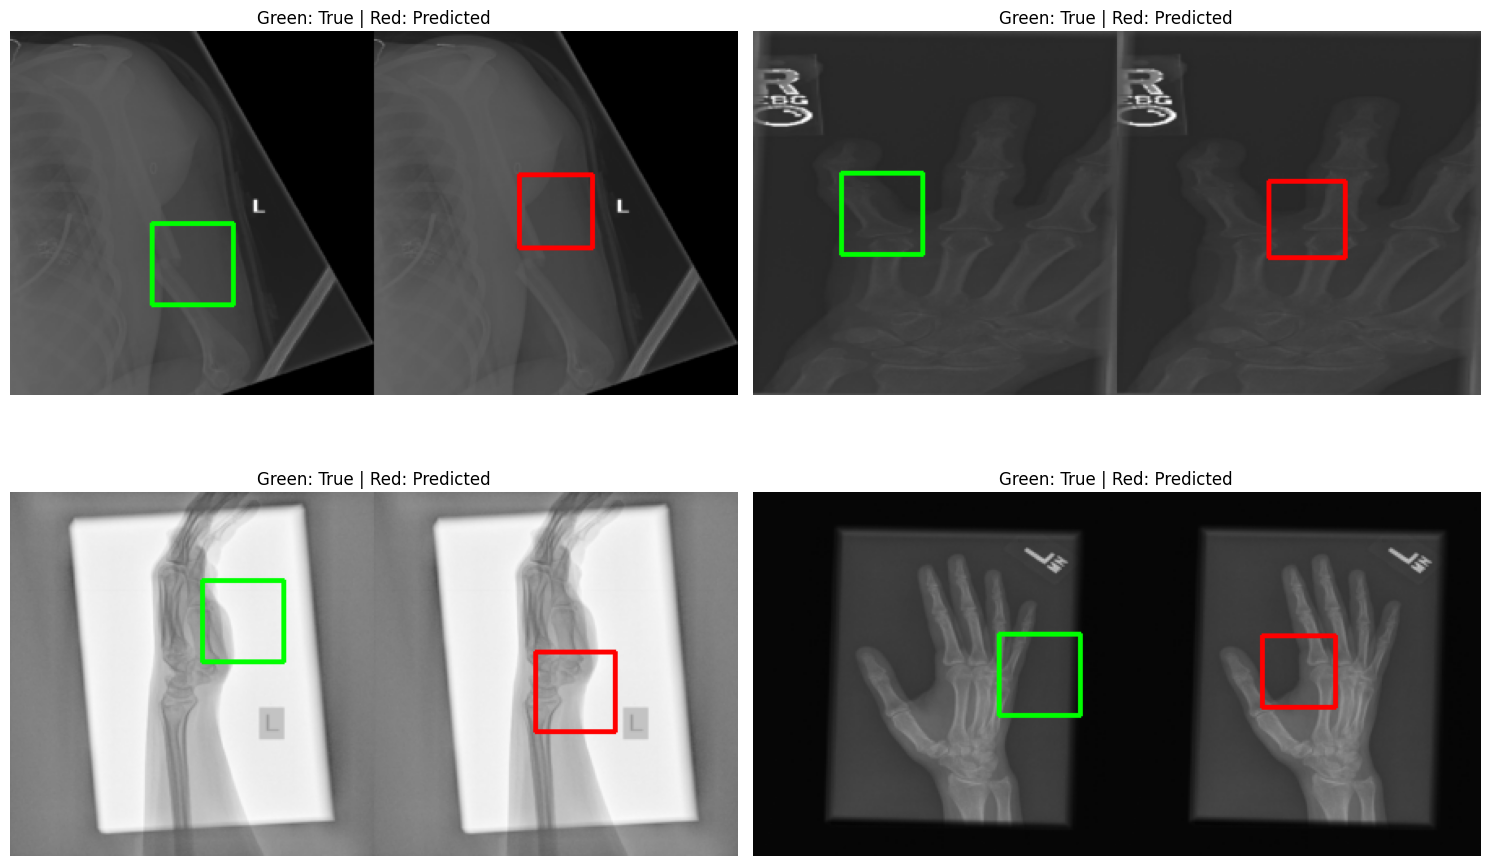

In [21]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import EfficientNet_B3_Weights
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

def visualize_bbox(model_path="best_bbox_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class BBoxModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.base = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
            self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, 4)
        
        def forward(self, x):
            return self.base(x)

    model = BBoxModel().to(device)
    try:
        model.load_state_dict(
            torch.load(model_path, map_location=device, weights_only=True)
        )
    except RuntimeError as e:
        print(f"laod failed: {str(e)}")
        return
    
    model.eval()
    
    class RawBoundingBoxDataset(Dataset):
        def __init__(self, csv_path):
            self.df = pd.read_csv(csv_path)
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)), 
                transforms.ToTensor()
            ])
        
        def __len__(self):
            return len(self.df)
        
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img = Image.open(row["path"]).convert("RGB")
            tensor_img = self.transform(img)
            bbox = torch.tensor([row["x1"], row["y1"], row["x2"], row["y2"]], dtype=torch.float32)
            return tensor_img, bbox
    
    dataset = RawBoundingBoxDataset("valid_bbox.csv")
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    with torch.no_grad():
        imgs, true_bboxes = next(iter(loader))
        imgs = imgs.to(device)
        pred_bboxes = model(imgs).cpu().numpy()
        true_bboxes = true_bboxes.numpy()
        
        plt.figure(figsize=(15, 10))
        for i in range(4):
            img = imgs[i].cpu().permute(1, 2, 0).numpy()
            img = (img * 255).astype(np.uint8)  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_true = img.copy()
            img_pred = img.copy()
            x1, y1, x2, y2 = true_bboxes[i].astype(int)
            cv2.rectangle(img_true, (x1, y1), (x2, y2), (0, 255, 0), 2)
            px1, py1, px2, py2 = pred_bboxes[i].astype(int)
            cv2.rectangle(img_pred, (px1, py1), (px2, py2), (255, 0, 0), 2)
            plt.subplot(2, 2, i+1)
            plt.imshow(np.hstack([img_true, img_pred]))
            plt.title(f"Green: True | Red: Predicted")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


visualize_bbox()